In [2]:
import pandas as pd
import numpy as np
import time_series_module as tsm
import time_series_cross_valid as tscv
import time_series_versioning as tsver
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from importlib import reload
from statsmodels.graphics import tsaplots
from statsmodels.api import tsa

In [3]:
df = pd.read_csv('train.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
date_time_features = tsm.get_date_time_features(df, 'date_time', 
                                                one_hot_encoding = {'hour' : True, 'day' : False, 'month' : False, 'season' : False}, 
                                                hour = True, day = True, month = True, season = False, year = False)

#date_time_features = df[date_time_features_names].copy()
date_time_column = df['date_time'].copy()
df.drop(columns = ['date_time'], inplace = True)

In [4]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

In [5]:
df

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,...,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,day,month
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,...,0,0,1,0,0,0,0,0,10,3
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,...,0,0,0,1,0,0,0,0,10,3
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,...,0,0,0,0,1,0,0,0,10,3
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,...,0,0,0,0,0,1,0,0,10,3
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,...,0,0,0,0,0,0,1,0,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,...,0,0,0,0,1,0,0,0,31,12
7107,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,...,0,0,0,0,0,1,0,0,31,12
7108,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,...,0,0,0,0,0,0,1,0,31,12
7109,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,...,0,0,0,0,0,0,0,1,31,12


In [6]:
sensors = ['sensor_{}'.format(i) for i in range(1,6)]

In [7]:
f_dict = {}
df = tsm.feature_extractor(features_dict = f_dict, data_frame = df, inplace = True, 
                           STL = [date_time_column, targets + sensors,
                                  True, False, 'additive'])
df.drop(columns = sensors, inplace = True)
#df = tsm.feature_extractor(features_dict = f_dict, data_frame = df, inplace = True, lagged = [list(df.columns), 24, False])

In [8]:
df.dropna(inplace = True)
#date_time_features = date_time_features.loc[list(df.index),:]
#date_time_column = date_time_column[df.index]
#df.index, date_time_column.index, date_time_features.index = [list(range(len(df)))]*3

In [9]:
def get_feature_list(data, date_time_features):
    return [f for f in list(data.columns) if f not in targets and f not in date_time_features and f != 'date_time']

In [11]:
features = get_feature_list(df, date_time_features)
features

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'trend_target_carbon_monoxide',
 'seasonal_target_carbon_monoxide',
 'resid_target_carbon_monoxide',
 'trend_target_benzene',
 'seasonal_target_benzene',
 'resid_target_benzene',
 'trend_target_nitrogen_oxides',
 'seasonal_target_nitrogen_oxides',
 'resid_target_nitrogen_oxides',
 'trend_sensor_1',
 'seasonal_sensor_1',
 'resid_sensor_1',
 'trend_sensor_2',
 'seasonal_sensor_2',
 'resid_sensor_2',
 'trend_sensor_3',
 'seasonal_sensor_3',
 'resid_sensor_3',
 'trend_sensor_4',
 'seasonal_sensor_4',
 'resid_sensor_4',
 'trend_sensor_5',
 'seasonal_sensor_5',
 'resid_sensor_5']

In [12]:
data_versions = tsver.DataVersions()

data_versions.push(tsver.nested_data(df, features, targets, targets, [date_time_column, date_time_features]), 
                   key = 'original_data')
data_versions.save_with_pickle('original_data')

In [157]:
rcParams['figure.figsize'] = 20, 8

In [14]:
def mape(y, y_hat):
    return 100*np.abs(y - y_hat) / y

### Ridge regression

In [15]:
from sklearn.linear_model import Ridge

In [16]:
class RidgeModel:
    def __init__(self, ridge):
        self.ridge = ridge
    def fit(self, X,Y):
        fitted_model = self.ridge.fit(X, Y)
        self.importances = fitted_model.coef_
        return fitted_model
    def predict(self, X):
        return self.ridge.predict(X)

In [17]:
ridge_horizons = 1
ridge_obj = Ridge(alpha = .001, normalize = True)
ridge_model = RidgeModel(ridge_obj)
ridge_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
ridge_ForecastModel_params = {'features' : features, 'date_time' : date_time_features,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [18]:
ridge_quality = tscv.run_cv(data = df, targets = targets, horizons = ridge_horizons, CrossValid_params = ridge_CrossValid_params, 
            ForecastModel_params = ridge_ForecastModel_params, model = ridge_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

target_carbon_monoxide


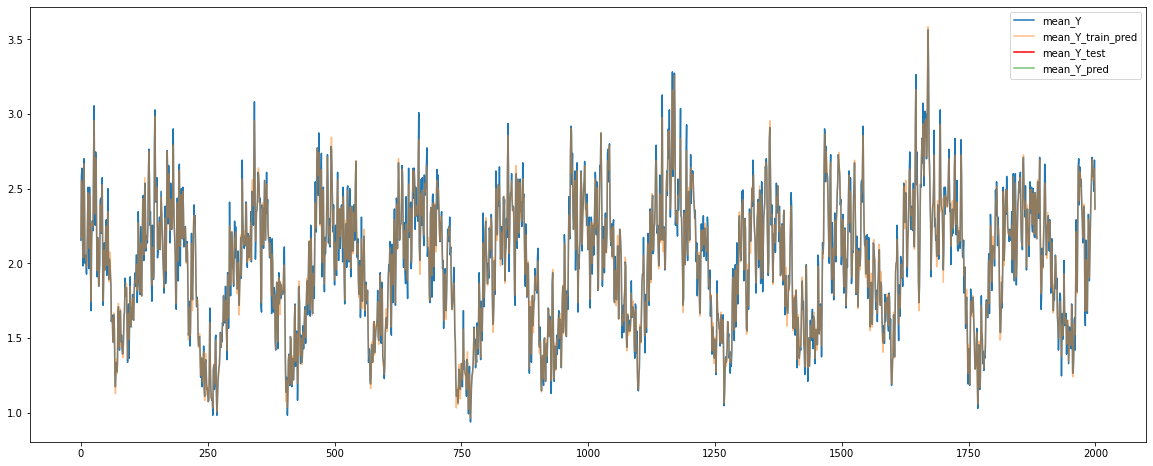

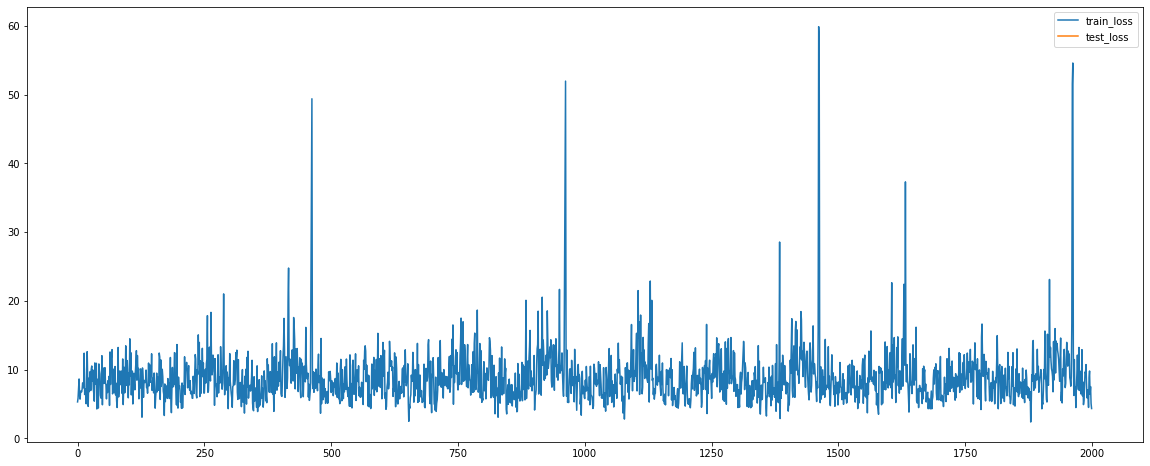

target_benzene


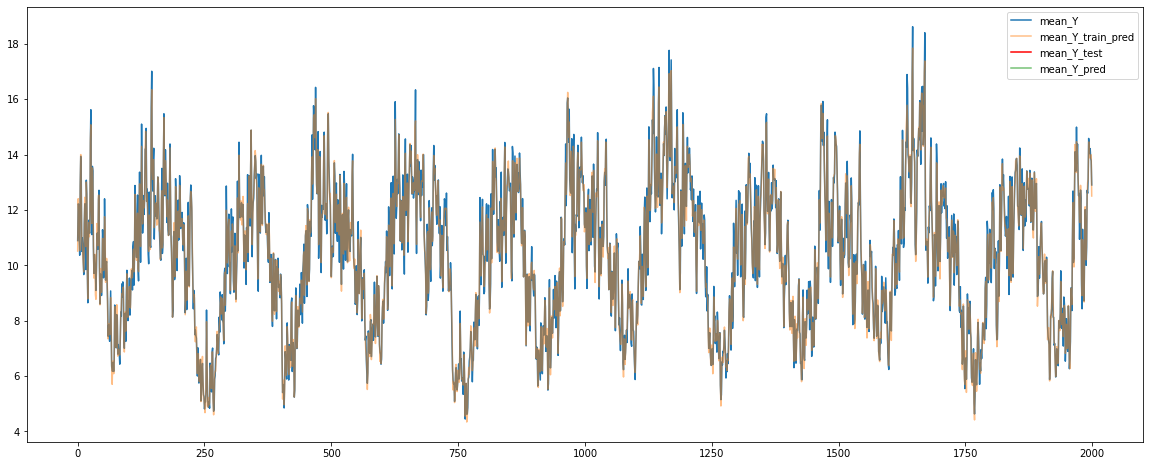

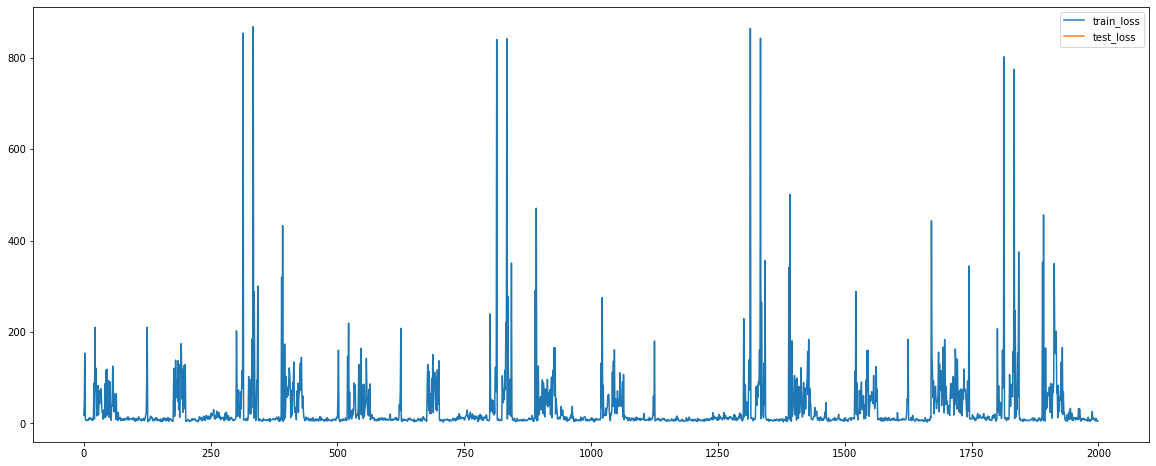

target_nitrogen_oxides


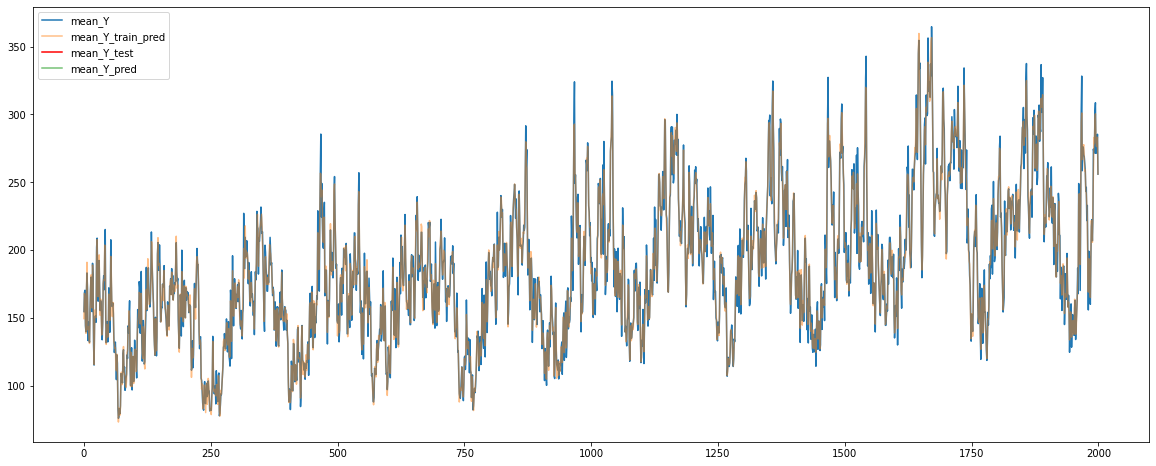

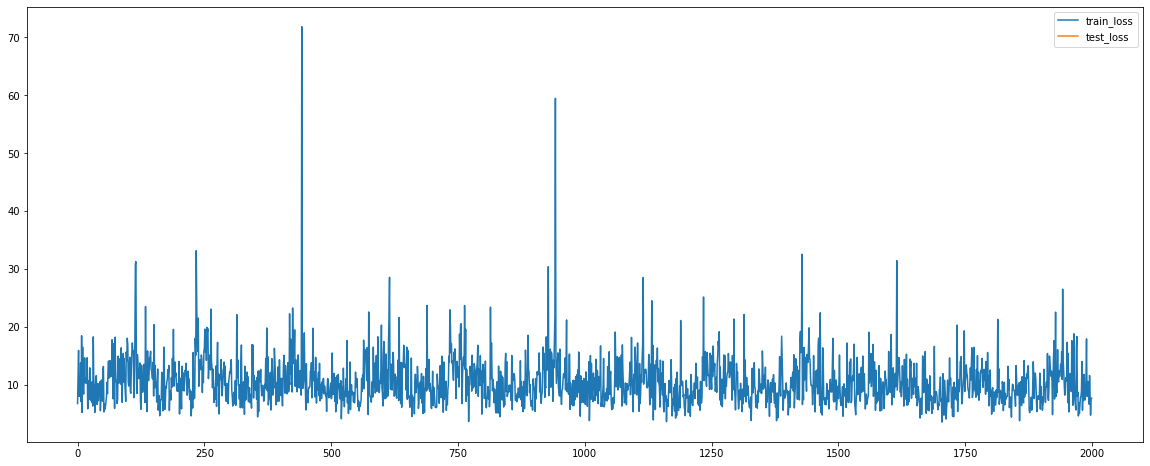

In [19]:
tscv.plot_cv_results(quality = ridge_quality, horizons = ridge_horizons, plot_loss = True)

In [20]:
ridge_losses = tscv.get_losses(ridge_quality, ridge_horizons)
for tar in targets:
    print(tar + ' train_loss: ',ridge_losses[tar]['train_loss'].mean())
    print(tar + ' test_loss: ',ridge_losses[tar]['test_loss'].mean())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

target_carbon_monoxide train_loss:  8.863817336816334
target_carbon_monoxide test_loss:  5.790547745387779
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_benzene train_loss:  32.457789999721946
target_benzene test_loss:  7.791311352540816
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_nitrogen_oxides train_loss:  10.468308910228092
target_nitrogen_oxides test_loss:  8.722992182760596
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [21]:
ridge_resid = tscv.get_residuals(ridge_quality, ridge_horizons)

[]

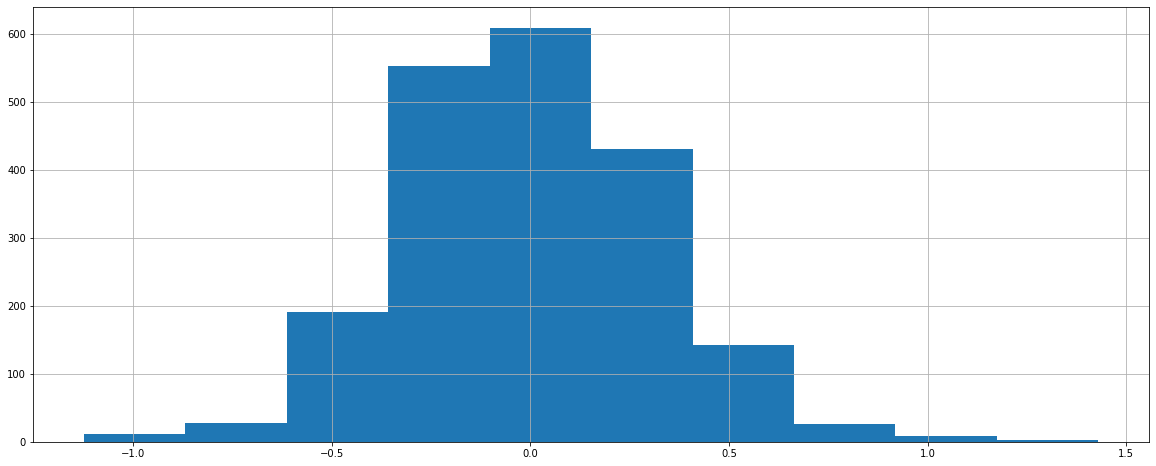

In [22]:
ridge_resid['target_benzene']['train_resid'].hist().plot()

[]

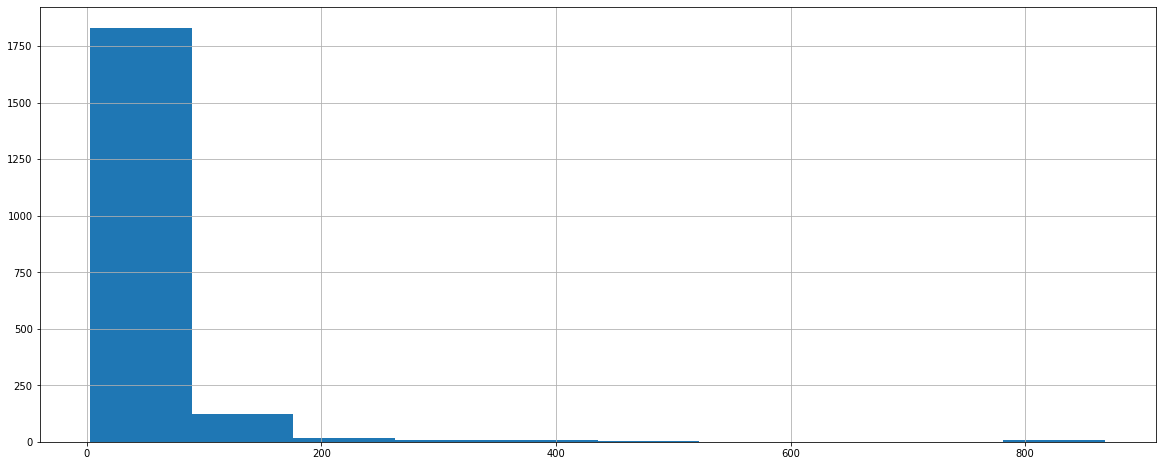

In [23]:
ridge_losses['target_benzene']['train_loss'].hist().plot()

<AxesSubplot:ylabel='Frequency'>

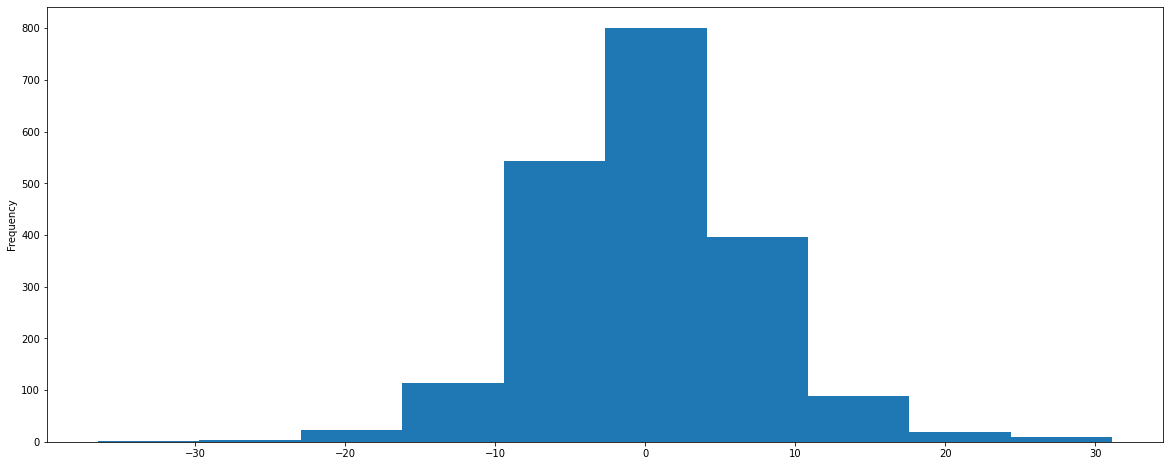

In [24]:
ridge_resid[targets[2]]['train_resid'].plot.hist()

In [25]:
ridge_columns = ridge_quality['target_benzene']['forecast_model'][0].features + ridge_quality['target_benzene']['forecast_model'][0].targets
ridge_feature_corr = ridge_quality['target_benzene']['forecast_model'][0].data[ridge_columns].corr()

In [27]:
#ridge_feature_corr.loc[ridge_feature_corr.loc['lag_sensor_2_1'] >= 0.8, ridge_feature_corr.loc['lag_sensor_2_1'] >= 0.8]

In [28]:
ridge_importances_dict = tscv.get_importances(ridge_quality, ridge_horizons)
ridge_imp_features_0 = ridge_importances_dict['target_carbon_monoxide'][0]#[(ridge_importances_dict['target_carbon_monoxide'][0] >= .2) | (ridge_importances_dict['target_carbon_monoxide'][0] <= -0.2)]
ridge_imp_features_1 = ridge_importances_dict['target_benzene'][0]
ridge_imp_features_2 = list(ridge_importances_dict['target_nitrogen_oxides'][0][(ridge_importances_dict['target_nitrogen_oxides'][0] >= 1) | (ridge_importances_dict['target_nitrogen_oxides'][0] <= -1)].index)

In [31]:
ridge_imp_features_1.apply(np.abs).sort_values(ascending = False).head(30)

lag_trend_target_carbon_monoxide_11    12.583837
lag_trend_target_carbon_monoxide_12     8.780132
lag_trend_target_carbon_monoxide_9      3.020823
lag_trend_target_benzene_11             2.957426
lag_trend_target_carbon_monoxide_8      2.592938
lag_trend_target_benzene_12             1.886001
lag_trend_target_carbon_monoxide_10     1.713232
lag_trend_target_carbon_monoxide_7      1.441045
lag_trend_target_carbon_monoxide_4      1.364133
lag_trend_target_carbon_monoxide_5      1.279819
lag_trend_target_carbon_monoxide_21     1.268668
lag_trend_target_carbon_monoxide_3      1.100371
lag_trend_target_carbon_monoxide_16     1.084761
lag_trend_target_carbon_monoxide_17     1.080203
lag_trend_target_carbon_monoxide_13     1.053231
lag_resid_target_carbon_monoxide_1      1.043591
lag_trend_target_carbon_monoxide_6      1.015331
lag_trend_target_carbon_monoxide_20     1.005554
lag_trend_target_benzene_10             1.005173
lag_resid_target_carbon_monoxide_22     0.987376
lag_resid_target_car

In [35]:
for ind in ridge_imp_features_1.sort_values(ascending = False).apply(np.abs).index:
    if 'sensor_2' in ind:
        print(ind,ridge_imp_features_0.apply(np.abs)[ind])

lag_trend_sensor_2_11 0.00469361639722374
lag_trend_sensor_2_12 0.004246756438493615
lag_trend_sensor_2_10 0.0009644604762045604
lag_seasonal_sensor_2_24 0.0005350359020081816
lag_seasonal_sensor_2_1 0.00011550300332926134
lag_seasonal_sensor_2_19 5.556043467831821e-05
lag_seasonal_sensor_2_21 2.9934820779637563e-05
lag_seasonal_sensor_2_3 1.3333005366660928e-05
lag_seasonal_sensor_2_17 4.976983919084714e-05
lag_seasonal_sensor_2_6 8.011372901009914e-06
lag_seasonal_sensor_2_12 5.629135826201143e-05
lag_seasonal_sensor_2_14 0.00010292501020263388
lag_seasonal_sensor_2_4 3.140766906790774e-05
lag_seasonal_sensor_2_9 3.57321472894568e-06
lag_seasonal_sensor_2_10 1.942681560398813e-05
lag_seasonal_sensor_2_7 8.292144996134509e-06
lag_seasonal_sensor_2_11 8.404418453596044e-05
lag_seasonal_sensor_2_23 3.7377117610504603e-06
lag_seasonal_sensor_2_8 7.356583253207174e-05
lag_seasonal_sensor_2_15 1.474684153955162e-05
lag_seasonal_sensor_2_5 1.4291898129440648e-05
lag_seasonal_sensor_2_16 3.1

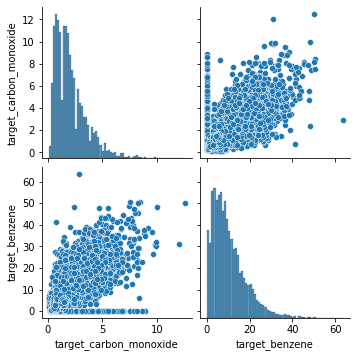

In [36]:
sns.pairplot(pd.concat([df[targets[0]].shift(1).dropna(), df[targets[1]]], axis = 1))

### Forward Selection

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [29]:
ridge_temp = ridge_quality['target_carbon_monoxide']['forecast_model'][0]

In [30]:
X_temp = ridge_temp.data[ridge_temp.features + ridge_temp.date_time].copy()
Y_temp = ridge_temp.data[ridge_temp.targets].copy()

In [31]:
sfs_cv = tscv.CrossValid(2000, 1)

In [32]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
MSE_scorer = make_scorer(MSE)
sfs = SequentialFeatureSelector(ridge_obj, cv = list(sfs_cv.split(len(Y_temp), step = 500)), 
                                k_features = 20, scoring = MSE_scorer, forward = True)
sfs = sfs.fit(X_temp, Y_temp)

In [33]:
X_temp.shape

(7106, 111)

In [34]:
sfs.k_feature_names_

('lag_deg_C_5',
 'lag_relative_humidity_1',
 'lag_sensor_1_5',
 'lag_sensor_4_4',
 'lag_seasonal_target_carbon_monoxide_3',
 'lag_resid_target_carbon_monoxide_1',
 'lag_resid_target_benzene_3',
 'lag_resid_target_nitrogen_oxides_3',
 'lag_resid_target_nitrogen_oxides_5',
 'h_8',
 'h_9',
 'h_10',
 'h_12',
 'h_15',
 'h_16',
 'h_17',
 'h_18',
 'h_20',
 'h_23',
 'day')

In [35]:
ridge_temp.data[list(sfs.k_feature_names_) + ridge_temp.targets].corr()

,lag_deg_C_5,lag_relative_humidity_1,lag_sensor_1_5,lag_sensor_4_4,lag_seasonal_target_carbon_monoxide_3,lag_resid_target_carbon_monoxide_1,lag_resid_target_benzene_3,lag_resid_target_nitrogen_oxides_3,lag_resid_target_nitrogen_oxides_5,h_8,...,h_10,h_12,h_15,h_16,h_17,h_18,h_20,h_23,day,lag_target_carbon_monoxide_0
lag_deg_C_5,1.000000,-0.492767,0.017206,0.296598,0.215942,-0.026502,-0.016989,-0.045782,-0.046710,-0.093885,...,-0.109252,-0.106305,0.031355,0.078097,0.105387,0.120009,0.128062,0.077104,-0.081860,-0.065601
lag_relative_humidity_1,-0.492767,1.000000,0.100268,-0.030461,-0.285108,0.043936,0.006916,0.037513,0.004822,0.132775,...,0.039130,-0.099048,-0.148341,-0.151336,-0.149624,-0.131589,-0.058630,0.031666,-0.061842,0.019782
lag_sensor_1_5,0.017206,0.100268,1.000000,0.545474,0.299265,0.019791,0.196047,0.163766,0.375690,-0.192864,...,-0.200586,0.043207,0.072487,0.032630,0.025970,0.015395,0.008872,0.150289,-0.011717,0.197424
lag_sensor_4_4,0.296598,-0.030461,0.545474,1.000000,0.351356,0.066510,0.330262,0.230955,0.234913,-0.142571,...,-0.086901,0.155587,0.017135,0.010570,0.010353,-0.019572,0.002996,0.127307,-0.110512,0.101508
lag_seasonal_target_carbon_monoxide_3,0.215942,-0.285108,0.299265,0.351356,1.000000,0.000240,0.000238,0.000472,0.000289,-0.346221,...,0.009429,0.195746,0.025375,0.026690,-0.006176,-0.013327,0.204229,0.285696,-0.000212,0.125454
lag_resid_target_carbon_monoxide_1,-0.026502,0.043936,0.019791,0.066510,0.000240,1.000000,0.308768,0.365281,0.072976,-0.000031,...,-0.000031,-0.000031,-0.000031,-0.000031,-0.000031,-0.000031,0.000808,-0.000031,-0.000796,0.411955
lag_resid_target_benzene_3,-0.016989,0.006916,0.196047,0.330262,0.000238,0.308768,1.000000,0.695284,0.303617,0.000033,...,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.001053,0.083784
lag_resid_target_nitrogen_oxides_3,-0.045782,0.037513,0.163766,0.230955,0.000472,0.365281,0.695284,1.000000,0.454118,0.000028,...,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,-0.001447,0.143190
lag_resid_target_nitrogen_oxides_5,-0.046710,0.004822,0.375690,0.234913,0.000289,0.072976,0.303617,0.454118,1.000000,0.000069,...,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,-0.002339,0.022584
h_8,-0.093885,0.132775,-0.192864,-0.142571,-0.346221,-0.000031,0.000033,0.000028,0.000069,1.000000,...,-0.043465,-0.043465,-0.043465,-0.043465,-0.043465,-0.043465,-0.043465,-0.043542,0.000071,0.145190


In [36]:
sfs.k_feature_names_

('lag_deg_C_5',
 'lag_relative_humidity_1',
 'lag_sensor_1_5',
 'lag_sensor_4_4',
 'lag_seasonal_target_carbon_monoxide_3',
 'lag_resid_target_carbon_monoxide_1',
 'lag_resid_target_benzene_3',
 'lag_resid_target_nitrogen_oxides_3',
 'lag_resid_target_nitrogen_oxides_5',
 'h_8',
 'h_9',
 'h_10',
 'h_12',
 'h_15',
 'h_16',
 'h_17',
 'h_18',
 'h_20',
 'h_23',
 'day')

In [37]:
#('lag_deg_C_1','lag_deg_C_2','lag_deg_C_3','lag_deg_C_4','lag_deg_C_5','lag_relative_humidity_1','lag_relative_humidity_2','lag_relative_humidity_3','lag_relative_humidity_4','lag_relative_humidity_5','lag_sensor_1_5','lag_sensor_2_5','lag_sensor_3_4','lag_sensor_4_4','lag_seasonal_target_carbon_monoxide_3','lag_resid_target_carbon_monoxide_1','lag_resid_target_carbon_monoxide_2','lag_resid_target_carbon_monoxide_3','lag_resid_target_benzene_2','lag_resid_target_benzene_3','lag_resid_target_nitrogen_oxides_1','lag_resid_target_nitrogen_oxides_2','lag_resid_target_nitrogen_oxides_3','lag_resid_target_nitrogen_oxides_5','h_0','h_6','h_8','h_9','h_10','h_12','h_13','h_14','h_15','h_16','h_17','h_18','h_20','h_21','h_23','day')

### Decision Tree

In [135]:
df1 = pd.read_csv('train.csv')
df1['date_time'] = pd.to_datetime(df1['date_time'])
date_time_features1 = tsm.get_date_time_features(df1, 'date_time', 
                                                one_hot_encoding = {'hour' : True, 'day' : True, 'month' : True, 'season' : True}, 
                                                hour = True, day = True, month = True, season = False, year = False)

#date_time_features = df[date_time_features_names].copy()
date_time_column1 = df1['date_time'].copy()
df1.drop(columns = ['date_time'], inplace = True)
f1_dict = {}
df1 = tsm.feature_extractor(features_dict = f1_dict, data_frame = df1, inplace = True, 
                            STL = [date_time_column1, targets + sensors, True, False, 'additive'])
df1.drop(columns = sensors, inplace = True)

In [136]:
features1 = get_feature_list(df1)
features1

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'trend_target_carbon_monoxide',
 'seasonal_target_carbon_monoxide',
 'resid_target_carbon_monoxide',
 'trend_target_benzene',
 'seasonal_target_benzene',
 'resid_target_benzene',
 'trend_target_nitrogen_oxides',
 'seasonal_target_nitrogen_oxides',
 'resid_target_nitrogen_oxides',
 'trend_sensor_1',
 'seasonal_sensor_1',
 'resid_sensor_1',
 'trend_sensor_2',
 'seasonal_sensor_2',
 'resid_sensor_2',
 'trend_sensor_3',
 'seasonal_sensor_3',
 'resid_sensor_3',
 'trend_sensor_4',
 'seasonal_sensor_4',
 'resid_sensor_4',
 'trend_sensor_5',
 'seasonal_sensor_5',
 'resid_sensor_5']

In [137]:
from sklearn.tree import DecisionTreeRegressor

In [138]:
class DTRegModel:
    def __init__(self, model):
        self.model = model
    def fit(self, X, Y):
        fitted_model = self.model.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return self.model.predict(X)
    

In [139]:
dtreg_model = DTRegModel(DecisionTreeRegressor(max_depth = 11))
dtreg_horizons = 1
dtreg_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
dtreg_ForecastModel_params = {'features' : features1, 'date_time' : date_time_features1,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [140]:
dtreg_quality = tscv.run_cv(data = df1, targets = targets, horizons = dtreg_horizons, CrossValid_params = dtreg_CrossValid_params, 
            ForecastModel_params = dtreg_ForecastModel_params, model = dtreg_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

target_carbon_monoxide


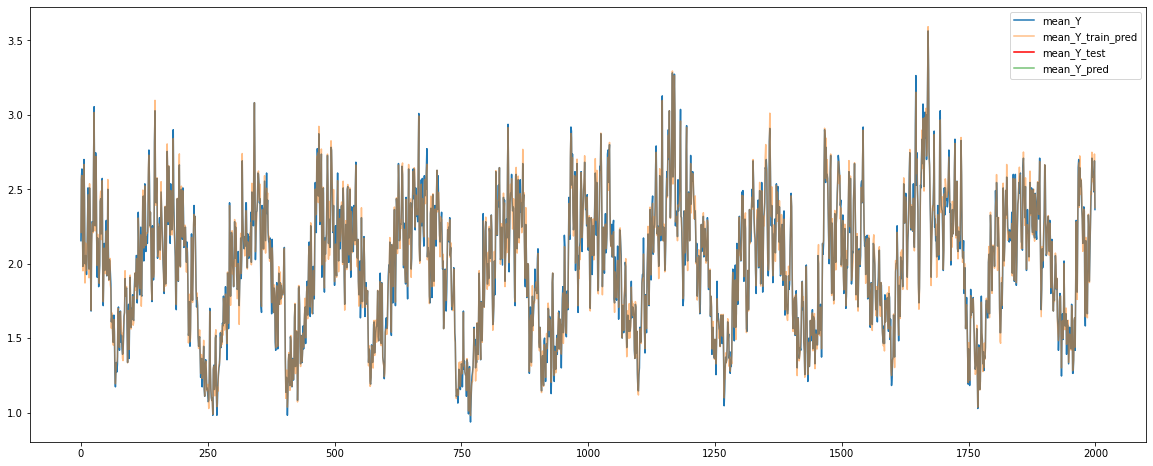

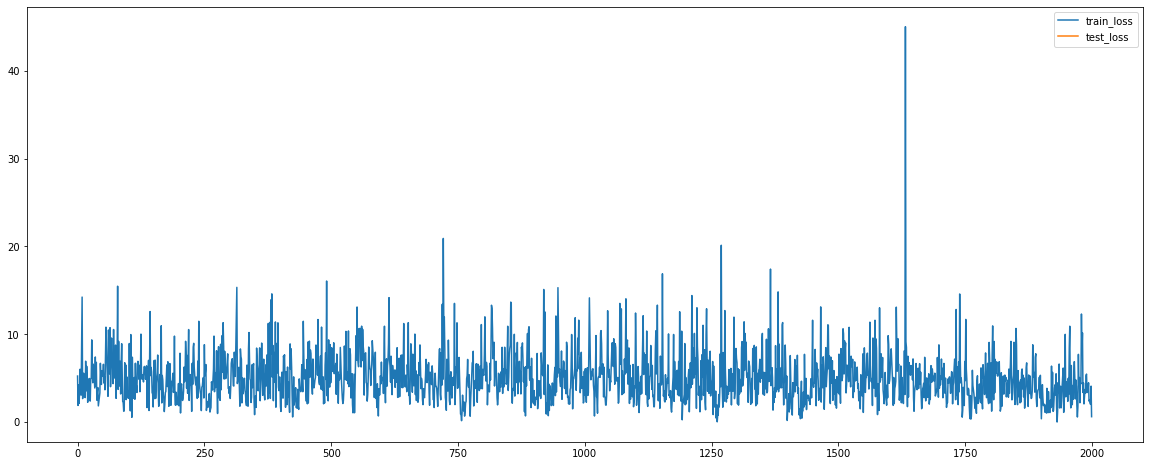

target_benzene


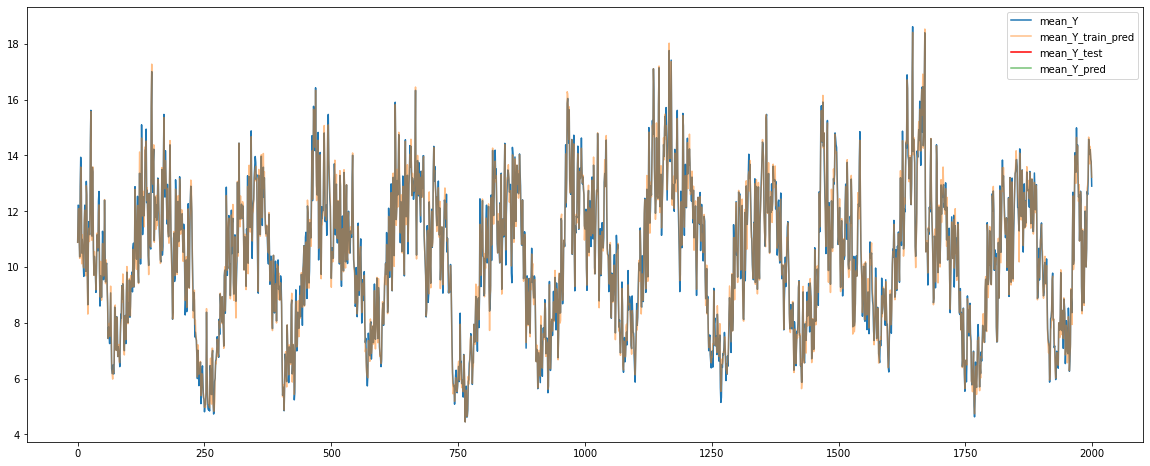

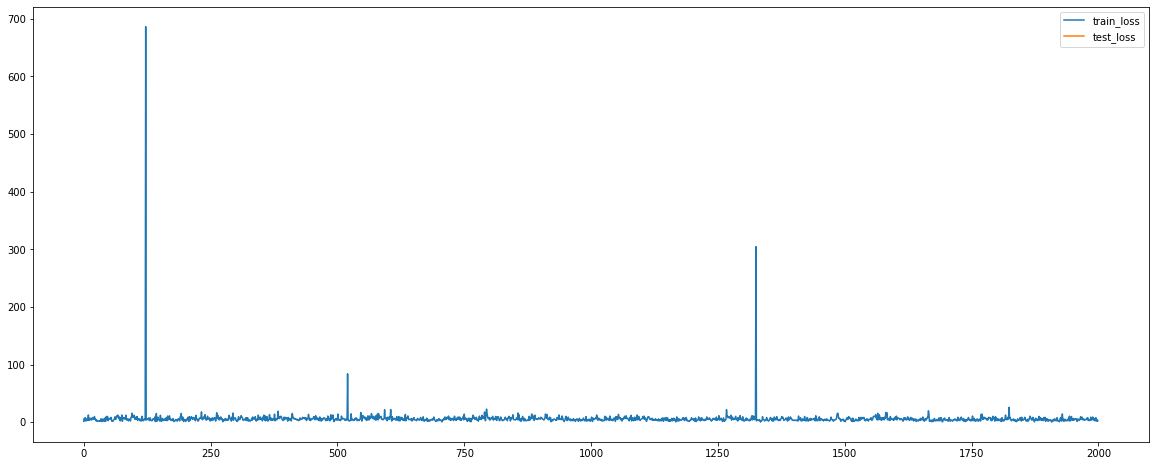

target_nitrogen_oxides


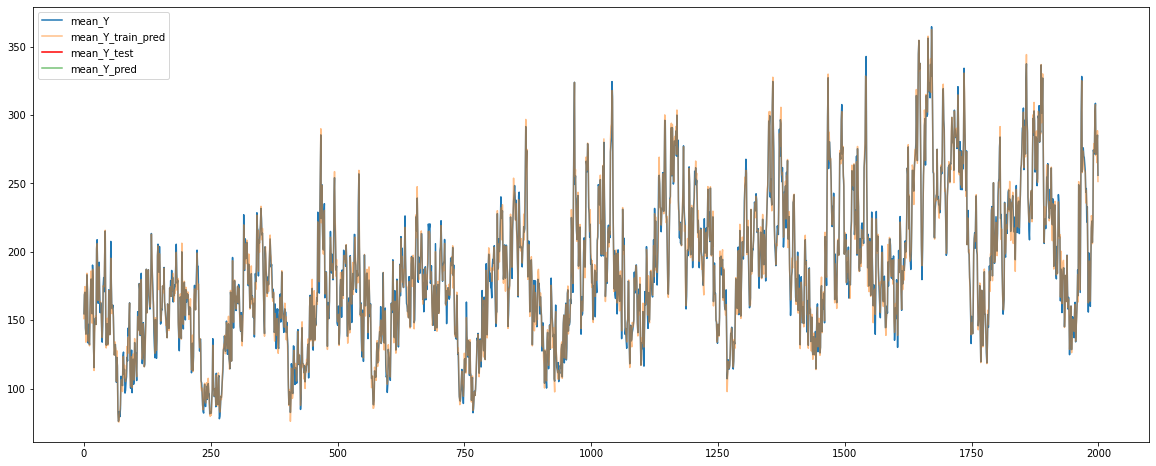

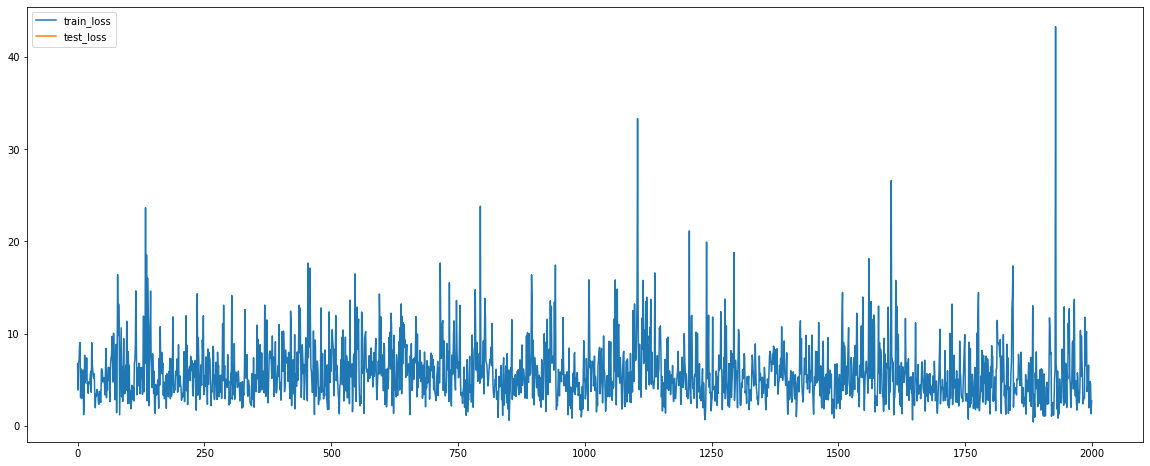

In [141]:
tscv.plot_cv_results(quality = dtreg_quality, horizons = dtreg_horizons, plot_loss = True)

In [142]:
dtreg_importances_dict = tscv.get_importances(dtreg_quality, dtreg_horizons, False)

dtreg_imp_features_0 = list(dtreg_importances_dict['target_carbon_monoxide'][0][(dtreg_importances_dict['target_carbon_monoxide'][0] >= .001) | (dtreg_importances_dict['target_carbon_monoxide'][0] <= -0.001)].index)
dtreg_imp_features_1 = list(dtreg_importances_dict['target_benzene'][0][(dtreg_importances_dict['target_benzene'][0] >= 1) | (dtreg_importances_dict['target_benzene'][0] <= -1)].index)
dtreg_imp_features_2 = list(dtreg_importances_dict['target_nitrogen_oxides'][0][(dtreg_importances_dict['target_nitrogen_oxides'][0] >= 1) | (dtreg_importances_dict['target_nitrogen_oxides'][0] <= -1)].index)

In [143]:
dtreg_losses = tscv.get_losses(dtreg_quality, dtreg_horizons)
for tar in targets:
    print(tar + ' train_loss: ',dtreg_losses[tar]['train_loss'].mean())
    print(tar + ' test_loss: ',dtreg_losses[tar]['test_loss'].mean())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

target_carbon_monoxide train_loss:  5.061133291702257
target_carbon_monoxide test_loss:  19.088557341551486
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_benzene train_loss:  6.013144222864641
target_benzene test_loss:  28.44068608135495
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_nitrogen_oxides train_loss:  5.70357296590992
target_nitrogen_oxides test_loss:  31.024406426269397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
dtlosses = {}
for tar in targets:
    dtlosses[tar] = {'train' : [], 'test' : []}
tree_height_list = list(range(5,11))
for tree_height in tree_height_list:
    dtreg_model = DTRegModel(DecisionTreeRegressor(max_depth = tree_height))
    dtreg_quality = tscv.run_cv(data = df, targets = targets, horizons = 2, CrossValid_params = dtreg_CrossValid_params, 
            ForecastModel_params = dtreg_ForecastModel_params, model = dtreg_model, metrics = mape)
    dtreg_losses = tscv.get_losses(dtreg_quality, 2)
    for tar in targets:
        dtlosses[tar]['train'].append(dtreg_losses[tar]['train_loss'].mean())
        dtlosses[tar]['test'].append(dtreg_losses[tar]['test_loss'].mean())

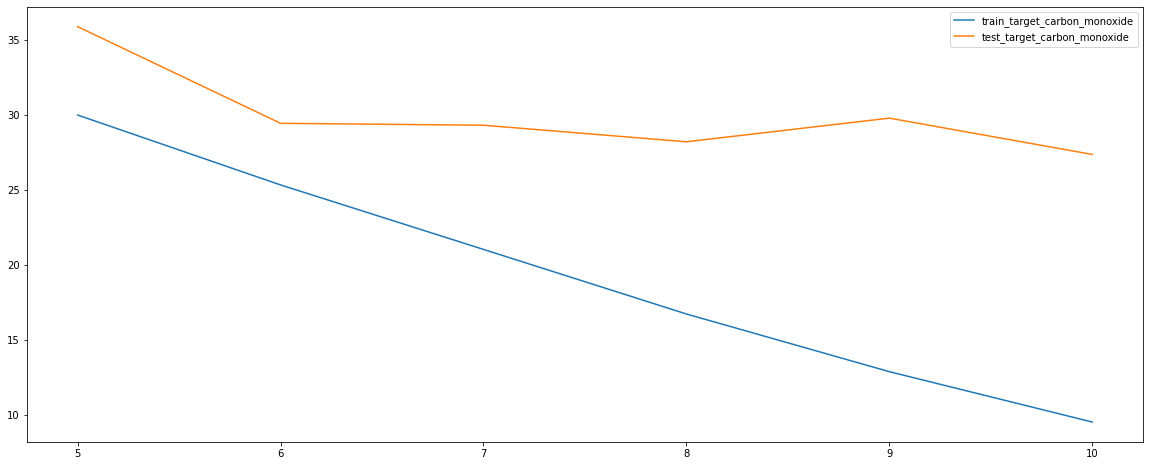

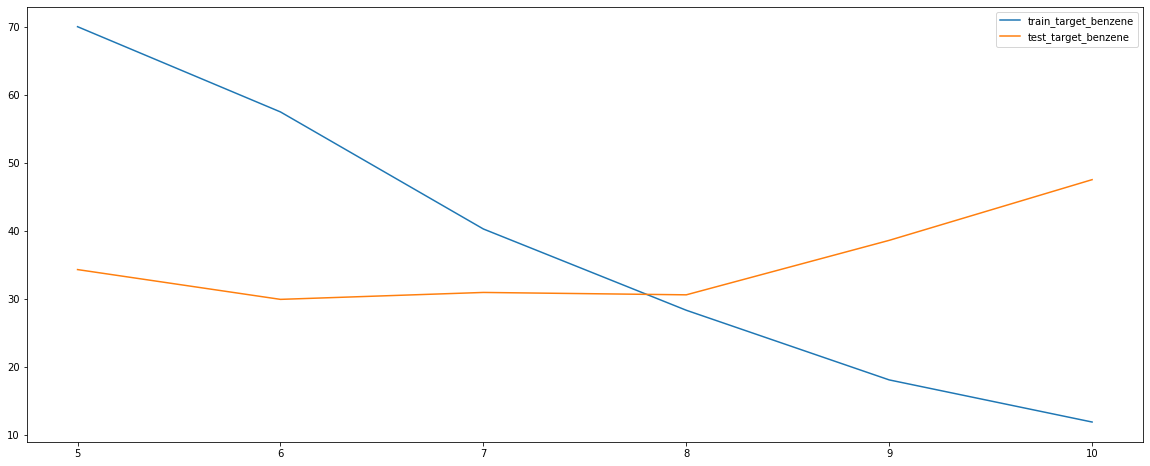

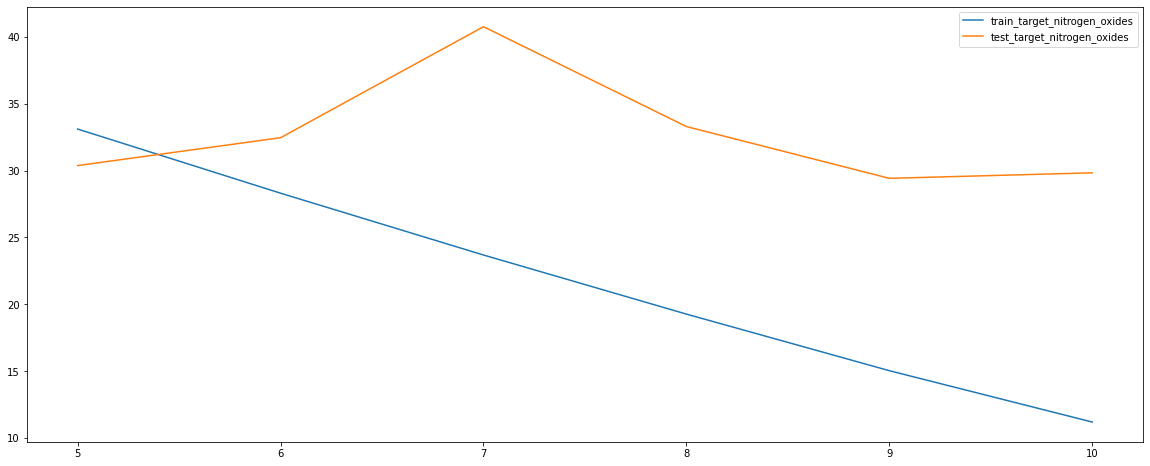

In [112]:
for tar in targets:
    plt.plot(tree_height_list, dtlosses[tar]['train'], label = 'train_' + tar)
    plt.plot(tree_height_list, dtlosses[tar]['test'], label = 'test_' + tar)
    plt.legend()
    plt.show()

In [94]:
dtreg_importances_dict['target_benzene'][0].sort_values(ascending = False)

lag_deg_C_1                           0.00004
lag_trend_sensor_3_14                 0.00004
lag_resid_sensor_2_20                 0.00004
lag_resid_sensor_2_21                 0.00004
lag_resid_sensor_2_22                 0.00004
                                       ...   
lag_trend_target_nitrogen_oxides_2    0.00004
lag_trend_target_nitrogen_oxides_3    0.00004
lag_trend_target_nitrogen_oxides_4    0.00004
lag_trend_target_nitrogen_oxides_5    0.00004
lag_resid_sensor_5_24                 0.00004
Length: 648, dtype: float64

### Random forest

In [146]:
rfdata = pd.read_csv('train.csv')
rfdata['date_time'] = pd.to_datetime(rfdata['date_time'])
rf_date_time_features = tsm.get_date_time_features(rfdata, 'date_time', 
                                                one_hot_encoding = {'hour' : True, 'day' : True, 'month' : True, 'season' : False}, 
                                                hour = True, day = True, month = True, season = False, year = False)

rf_date_time_column = rfdata['date_time'].copy()
rfdata.drop(columns = ['date_time'], inplace = True)

In [147]:
rf_features_dict = {}
rfdata = tsm.feature_extractor(features_dict = rf_features_dict, data_frame = rfdata, inplace = True, 
                            STL = [rf_date_time_column, targets + sensors, True, False, 'additive'])
rfdata.drop(columns = sensors, inplace = True)

In [151]:
rf_features = get_feature_list(rfdata)
rf_features

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'trend_target_carbon_monoxide',
 'seasonal_target_carbon_monoxide',
 'resid_target_carbon_monoxide',
 'trend_target_benzene',
 'seasonal_target_benzene',
 'resid_target_benzene',
 'trend_target_nitrogen_oxides',
 'seasonal_target_nitrogen_oxides',
 'resid_target_nitrogen_oxides',
 'trend_sensor_1',
 'seasonal_sensor_1',
 'resid_sensor_1',
 'trend_sensor_2',
 'seasonal_sensor_2',
 'resid_sensor_2',
 'trend_sensor_3',
 'seasonal_sensor_3',
 'resid_sensor_3',
 'trend_sensor_4',
 'seasonal_sensor_4',
 'resid_sensor_4',
 'trend_sensor_5',
 'seasonal_sensor_5',
 'resid_sensor_5']

In [152]:
from sklearn.ensemble import RandomForestRegressor

In [153]:
class RFReg_model:
    def __init__(self, rfreg):
        self.rfreg = rfreg
    def fit(self, X, Y):
        Y = np.reshape(Y, (Y.shape[0],))
        fitted_model = self.rfreg.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return np.reshape(self.rfreg.predict(X), (X.shape[0],1))

In [160]:
rfreg_model = RFReg_model(RandomForestRegressor(n_estimators = 35, max_depth = 5, bootstrap = False))
rfreg_horizons = 1
rfreg_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
rfreg_ForecastModel_params = {'features' : rf_features + targets, 'date_time' : rf_date_time_features,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [161]:
rfreg_quality = tscv.run_cv(data = rfdata, targets = targets, horizons = rfreg_horizons, CrossValid_params = rfreg_CrossValid_params, 
            ForecastModel_params = rfreg_ForecastModel_params, model = rfreg_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

target_carbon_monoxide


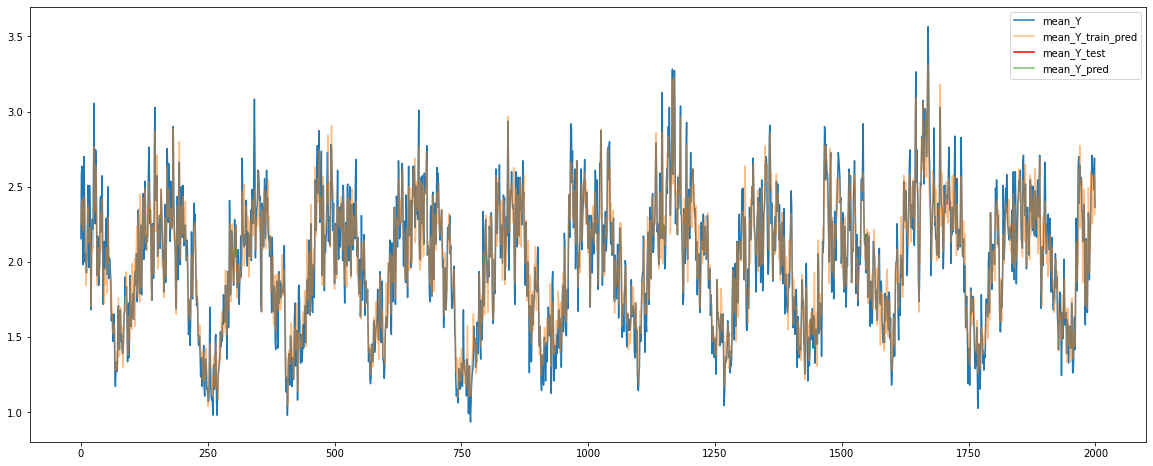

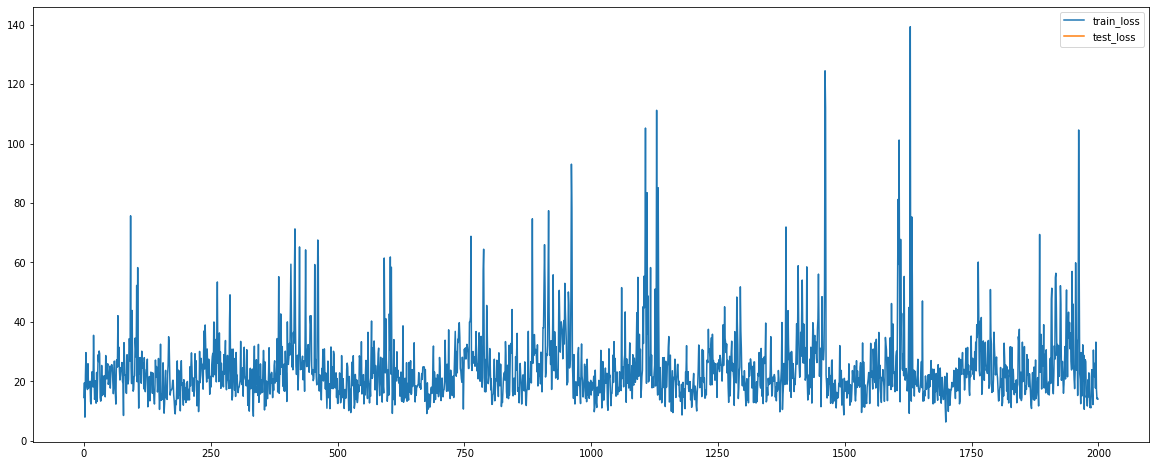

target_benzene


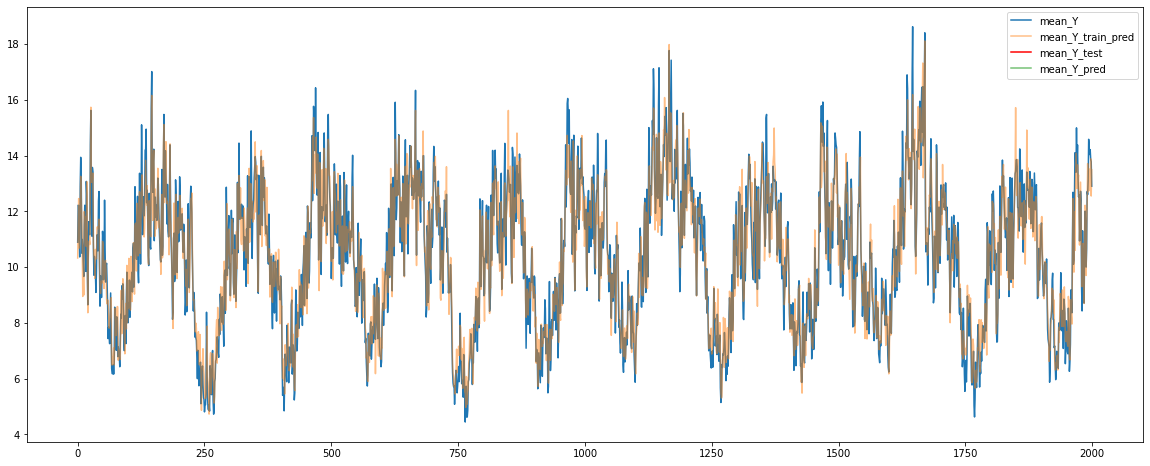

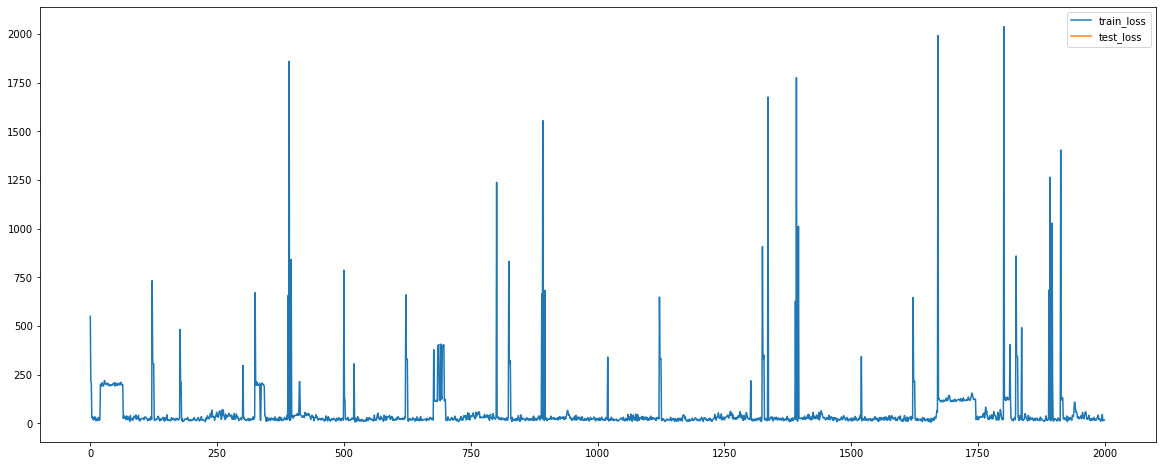

target_nitrogen_oxides


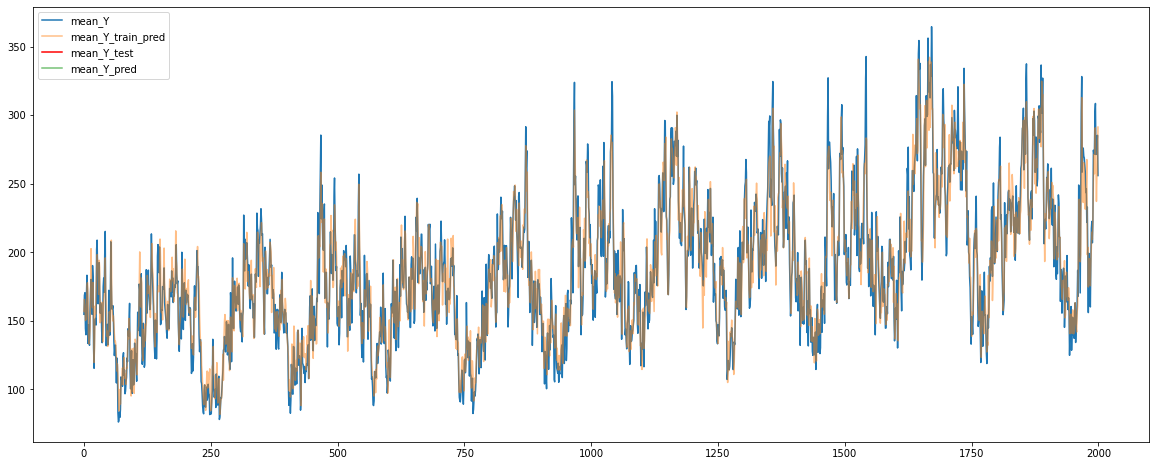

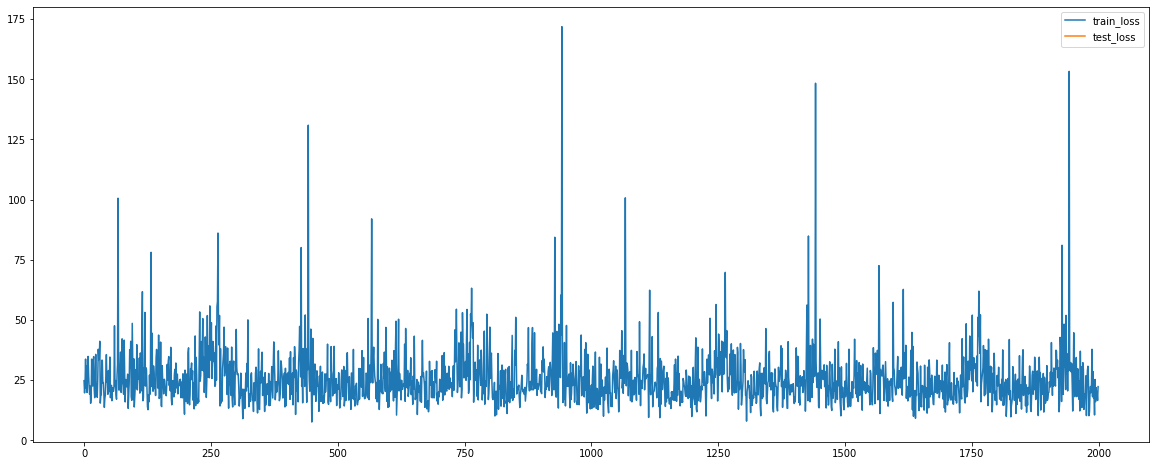

In [162]:
tscv.plot_cv_results(quality = rfreg_quality, horizons = rfreg_horizons, plot_loss = True)

In [163]:
rfreg_losses = tscv.get_losses(rfreg_quality, rfreg_horizons)
for tar in targets:
    print(tar + ' train_loss: ',rfreg_losses[tar]['train_loss'].mean())
    print(tar + ' test_loss: ',rfreg_losses[tar]['test_loss'].mean())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

target_carbon_monoxide train_loss:  23.96903300183821
target_carbon_monoxide test_loss:  15.754499402440556
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_benzene train_loss:  56.84076465733
target_benzene test_loss:  20.891113481153095
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_nitrogen_oxides train_loss:  25.550399831477677
target_nitrogen_oxides test_loss:  23.19790189227172
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [56]:
#rfreg_quality['target_benzene']['']

### Xgboost

In [408]:
reload(tsm)

<module 'time_series_module' from '/home/alexey/notebooks/EPAM/practice_1/time_series_module.py'>

In [409]:
xgb_data = pd.read_csv('train.csv')
xgb_data['date_time'] = pd.to_datetime(xgb_data['date_time'])
xgb_date_time_features = tsm.get_date_time_features(xgb_data, 'date_time', 
                                                one_hot_encoding = {'hour' : False, 'day' : False, 'month' : False, 'season' : False},
                                                hour = True, day = True, month = True, season = True, year = False)

xgb_date_time_column = xgb_data['date_time'].copy()
xgb_data.drop(columns = ['date_time'], inplace = True)

In [410]:
xgb_features_dict = {}
#xgbdata = tsm.feature_extractor(features_dict = xgb_features_dict, data_frame = xgb_data, inplace = True, 
#                            STL = [xgb_date_time_column, targets, True, False, 'additive'])
xgbdata = tsm.feature_extractor(features_dict = xgb_features_dict, data_frame = xgb_data, inplace = True, 
                            STL = [xgb_date_time_column, targets, True, False, 'additive'])
#xgbdata.drop(columns = sensors, inplace = True)

In [411]:
xgb_features = get_feature_list(xgb_data, xgb_date_time_features)
xgb_features

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'trend_target_carbon_monoxide',
 'seasonal_target_carbon_monoxide',
 'resid_target_carbon_monoxide',
 'trend_target_benzene',
 'seasonal_target_benzene',
 'resid_target_benzene',
 'trend_target_nitrogen_oxides',
 'seasonal_target_nitrogen_oxides',
 'resid_target_nitrogen_oxides']

In [412]:
from xgboost import XGBRegressor

In [413]:
class XGBRegModel:
    def __init__(self, model):
        self.model = model
    def fit(self, X, Y):
        fitted_model = self.model.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return self.model.predict(X)

In [430]:
xgb_model = XGBRegModel(XGBRegressor(n_estimators = 250, max_depth = 2))#, reg_alpha = 0.01, reg_lambda = 0.01))
xgb_horizons = 1
xgb_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
xgb_ForecastModel_params = {'features' : xgb_features, 'date_time' : xgb_date_time_features,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [431]:
xgb_quality = tscv.run_cv(data = xgb_data, targets = targets, horizons = xgb_horizons, CrossValid_params = xgb_CrossValid_params, 
                          ForecastModel_params = xgb_ForecastModel_params, model = xgb_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [432]:
xgb_losses = tscv.get_losses(xgb_quality, xgb_horizons)
for tar in targets:
    print(tar + ' train_loss: ',xgb_losses[tar]['train_loss'].mean())
    print(tar + ' test_loss: ',xgb_losses[tar]['test_loss'].mean())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

target_carbon_monoxide train_loss:  11.531734978111073
target_carbon_monoxide test_loss:  18.487642924718365
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_benzene train_loss:  31.264409604671542
target_benzene test_loss:  9.939855562184498
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
target_nitrogen_oxides train_loss:  13.088845569808734
target_nitrogen_oxides test_loss:  29.716884542024978
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [433]:
rcParams['figure.figsize'] = 30, 10

target_carbon_monoxide


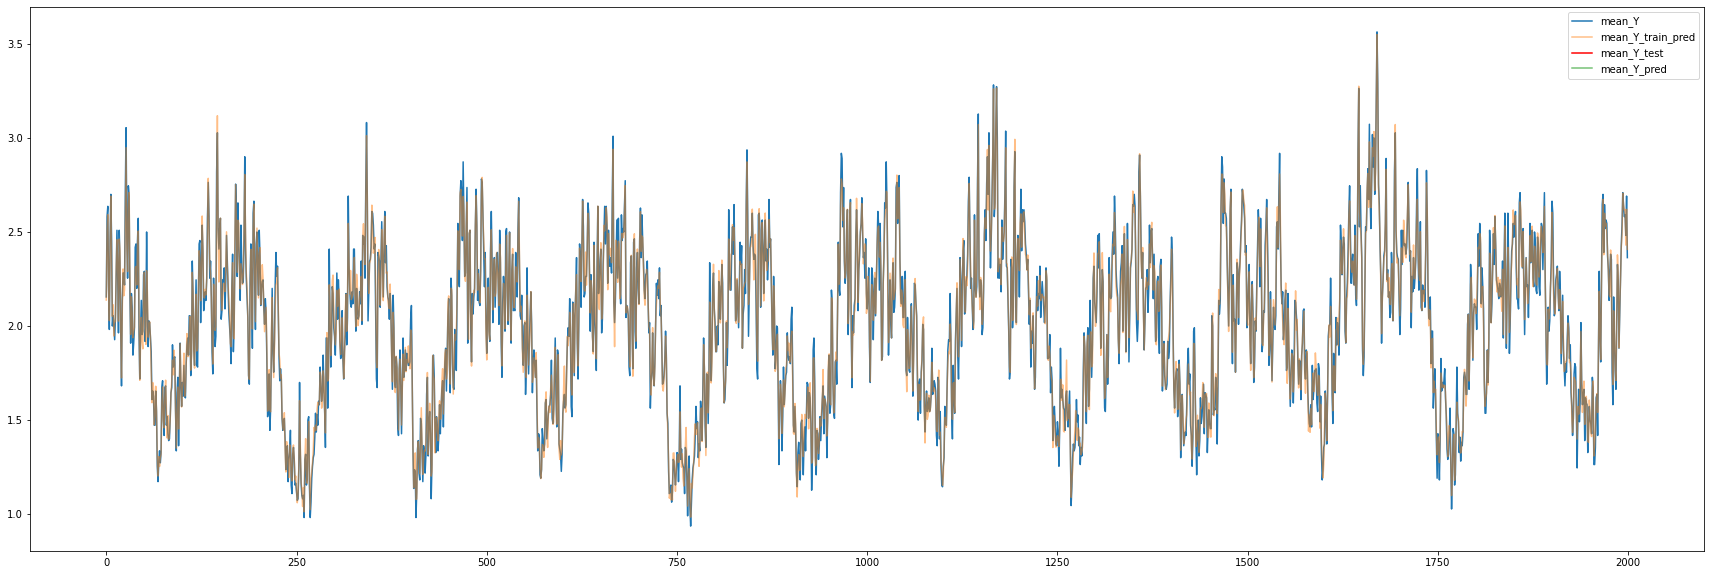

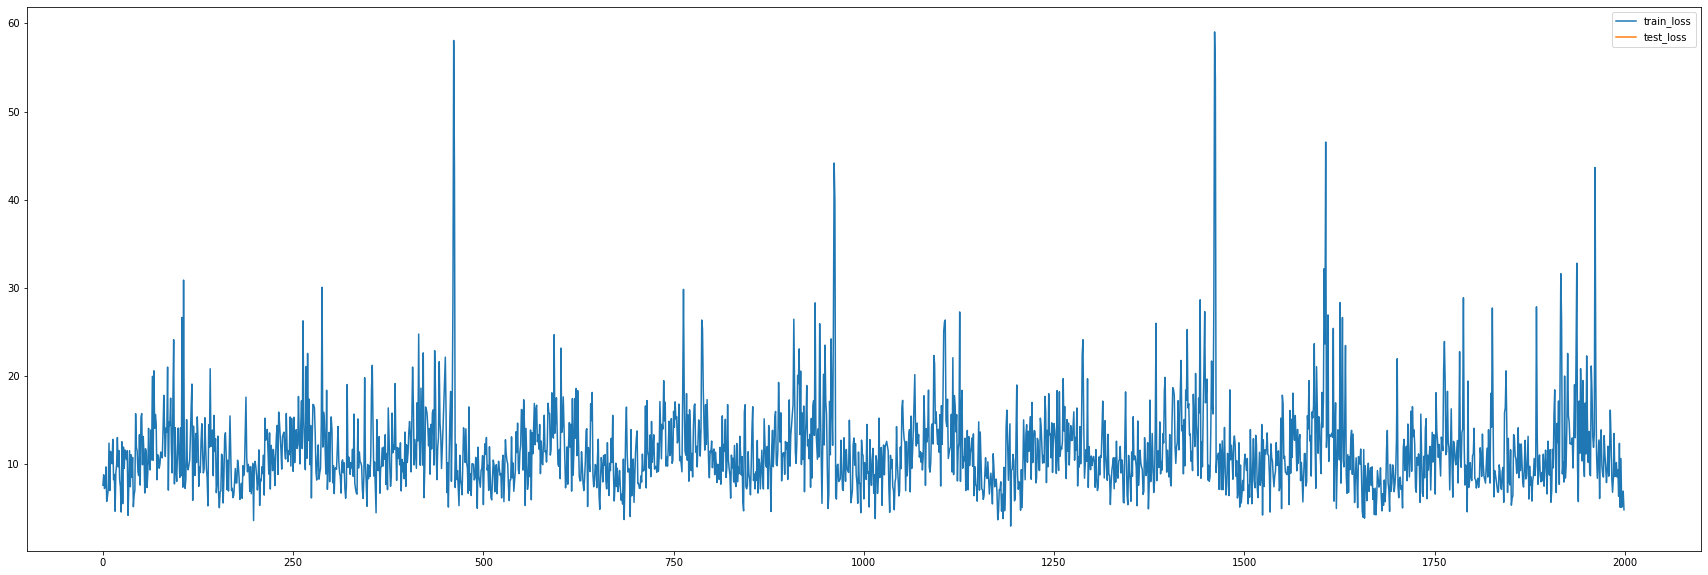

target_benzene


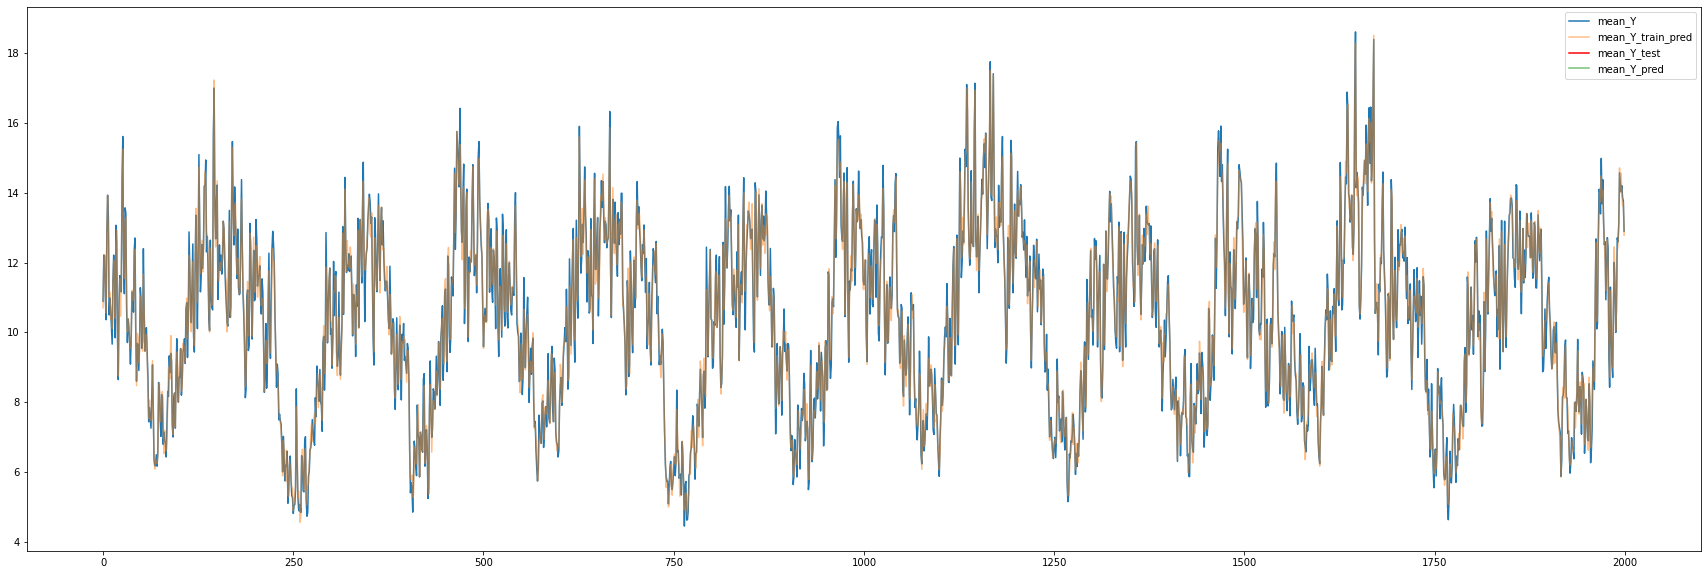

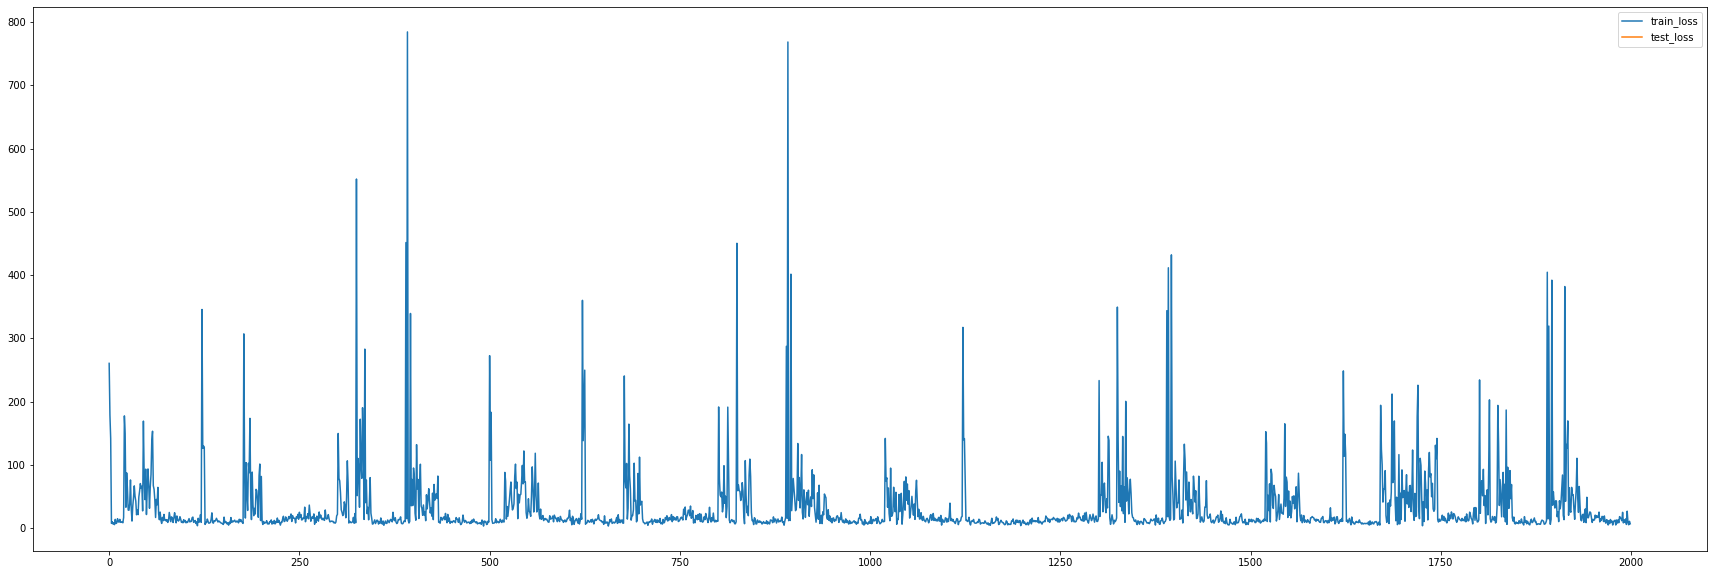

target_nitrogen_oxides


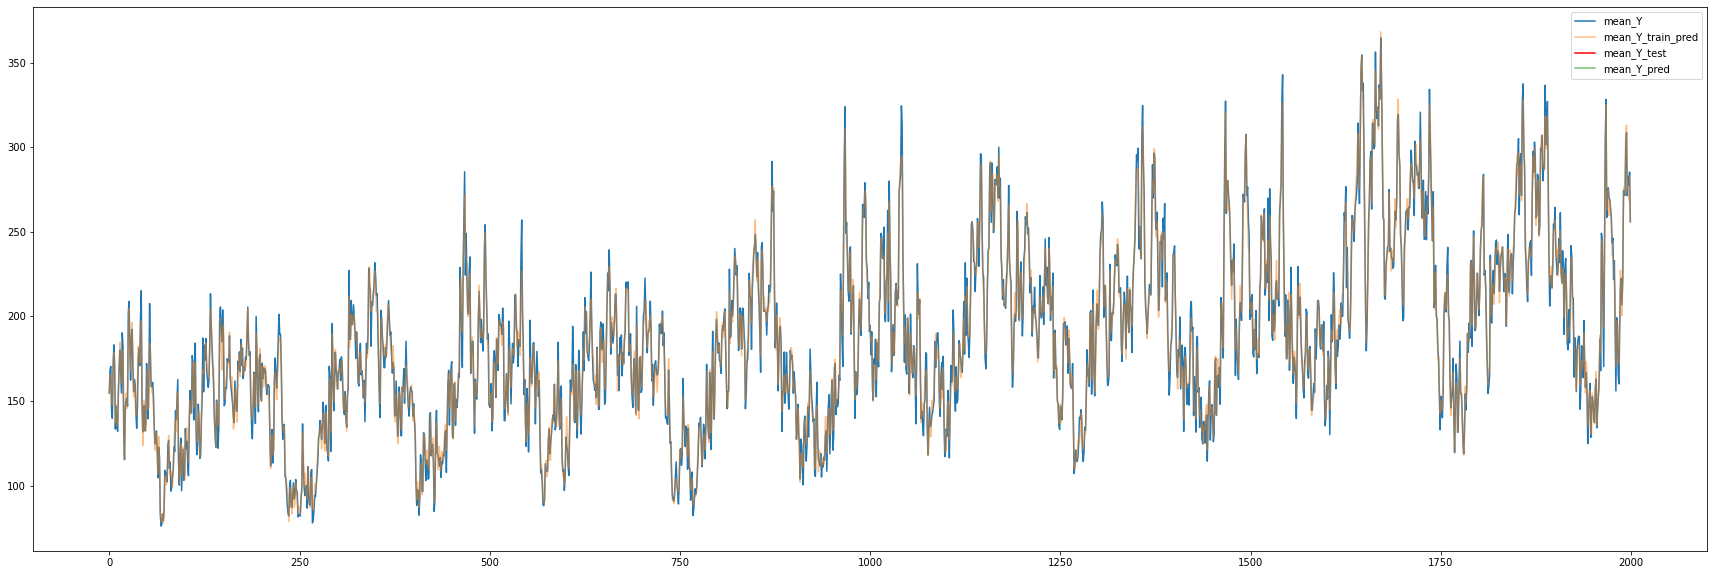

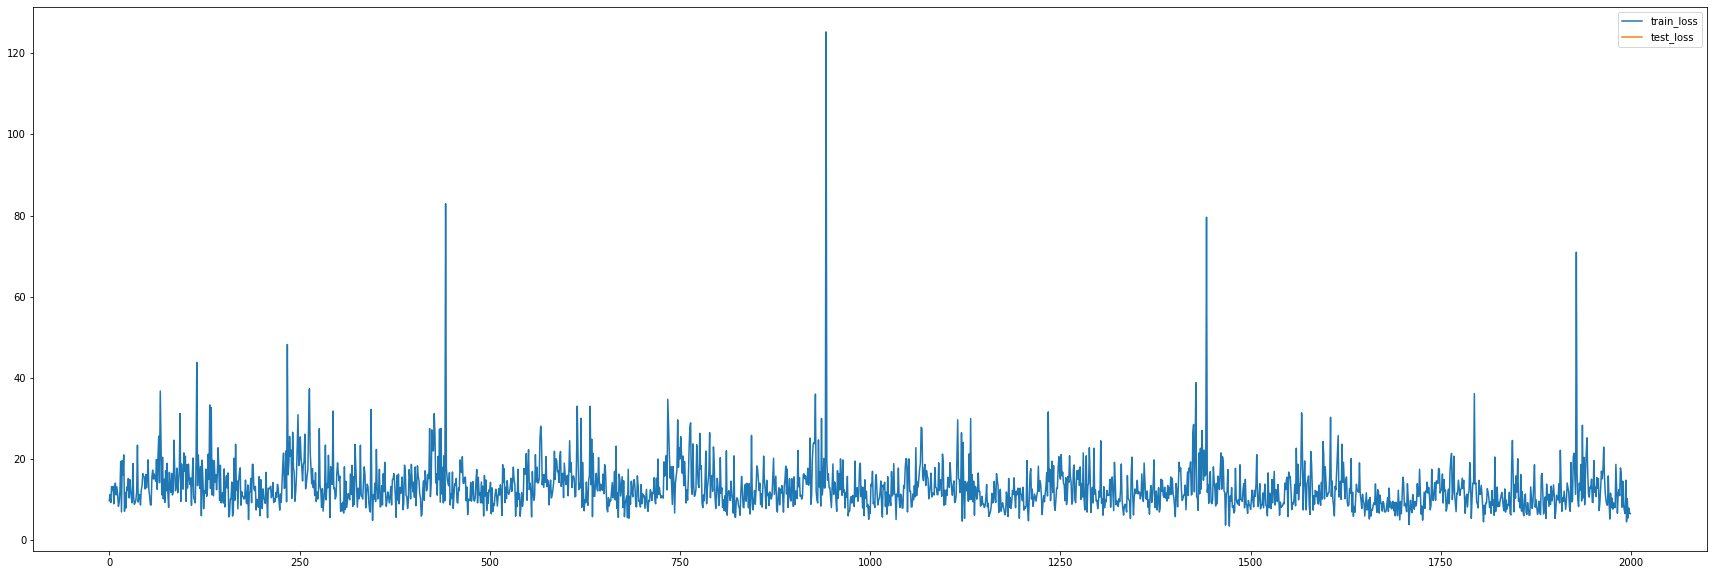

In [434]:
tscv.plot_cv_results(quality = xgb_quality, horizons = xgb_horizons, plot_loss = True)

In [435]:
xgb_losses, xgb_resids = tscv.get_losses(xgb_quality, xgb_horizons), tscv.get_residuals(xgb_quality, xgb_horizons)

In [337]:
xgb_quality[targets[0]]['forecast_model'][0] 

In [338]:
xgb_importances_dict = tscv.get_importances(xgb_quality, xgb_horizons, False)